### Implementing simple neural network from scratch
In this notebook I implemented a simple neural network without using advanced ML libraries.


In [281]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from common import *
import pickle

In [282]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward_pass(self, input):
        raise NotImplementedError

    def backpropagation(self, output_error, learning_rate):
        raise NotImplementedError

class FullyConnectedLayer(Layer):
    def __init__(self, input_size, output_size, init_method='random'):
        if init_method == 'random':
            self.weights = np.random.rand(input_size, output_size) - 0.5
            self.bias = np.random.rand(1, output_size) - 0.5
        elif init_method == 'zeros':
            self.weights = np.zeros((input_size, output_size))
            self.bias = np.zeros((1, output_size))
        elif init_method == 'xavier':
            self.weights = np.random.randn(input_size, output_size) * np.sqrt(2 / (input_size + output_size))
            self.bias = np.random.randn(1, output_size) * np.sqrt(2 / (input_size + output_size))
        elif init_method == 'he':
            self.weights = np.random.randn(input_size, output_size) * np.sqrt(2 / input_size)
            self.bias = np.random.randn(1, output_size) * np.sqrt(2 / input_size)

    def forward_pass(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    def backpropagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)

        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

class ActivationComponent(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward_pass(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    def backpropagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None
        self.convergence=[]
    def save(self, filename):
        with open(filename, 'wb.npnn') as f:
            #pickle the model
            pickle.dump(self, f)
    def add(self, layer):
        self.layers.append(layer)

    def set_loss(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    def predict(self, input_data):
        samples = len(input_data)
        result = []
        for i in range(samples):
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_pass(output)
            result.append(output)

        return result

    def fit(self, x_train, y_train, epochs, learning_rate, printc=False):
        samples = len(x_train)
        for i in range(epochs):
            err = 0
            for j in range(samples):
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_pass(output)
                err += self.loss(y_train[j], output)

                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backpropagation(error, learning_rate)
                    
            err /= samples
            self.convergence.append(err)
            if printc:
                print(f'Epoch: {i}, Error: {err}')
            

Data visualization
- Iris-setosa : red
- Iris-versicolor: green
- Iris-virginica: blue

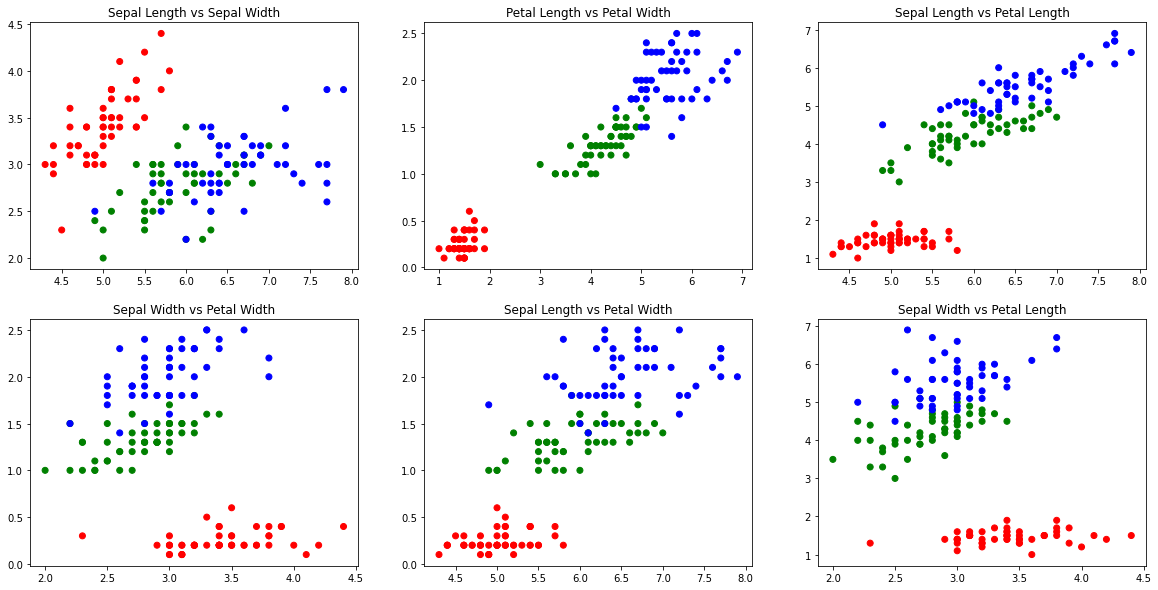

In [283]:
#get iris
iris = pd.read_csv('iris.csv')
plot_iris_data(iris)

Epoch: 0, Error: 0.21377440340519327
Epoch: 1, Error: 0.17221345319809978
Epoch: 2, Error: 0.14135128022807728
Epoch: 3, Error: 0.12287118054741303
Epoch: 4, Error: 0.11063887476598142
Epoch: 5, Error: 0.10092019449648036
Epoch: 6, Error: 0.09226796770297264
Epoch: 7, Error: 0.08422863900835577
Epoch: 8, Error: 0.07674783346659814
Epoch: 9, Error: 0.06990408762980888
Epoch: 10, Error: 0.0637788253380614
Epoch: 11, Error: 0.05840314084036231
Epoch: 12, Error: 0.053751824560396115
Epoch: 13, Error: 0.0497598397529888
Epoch: 14, Error: 0.046343135845527746
Epoch: 15, Error: 0.04341478753743018
Epoch: 16, Error: 0.04089444575354658
Epoch: 17, Error: 0.03871243218307909
Epoch: 18, Error: 0.03681053192709538
Epoch: 19, Error: 0.03514112575782133
Epoch: 20, Error: 0.033665682099980984
Epoch: 21, Error: 0.03235314732346632
Epoch: 22, Error: 0.031178477344702537
Epoch: 23, Error: 0.030121394975788734
Epoch: 24, Error: 0.029165381132036882
Epoch: 25, Error: 0.028296875831510578
Epoch: 26, Error:

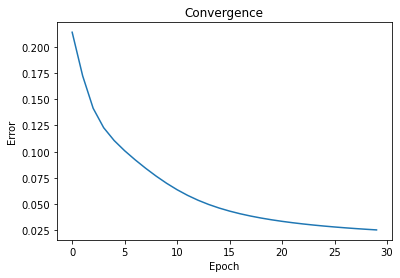

In [284]:
net = Network()
net.add(FullyConnectedLayer(4, 16, init_method='he'))
net.add(ActivationComponent(sigmoid, sigmoid_prime))
net.add(FullyConnectedLayer(16, 3, init_method='he'))
net.add(ActivationComponent(softmax, softmax_prime))

# convert species to one-hot encoding
iris['Species'] = iris['Species'].map({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})

# split data into training and test set (80%/20%)
iris_train = iris.sample(frac=0.8)
iris_test = iris.drop(iris_train.index)
# convert to numpy arrays
iris_train = iris_train.to_numpy()
iris_test = iris_test.to_numpy()

# normalize data (0-1)
for i in range(4):
    iris_train[:, i] = (iris_train[:, i] - iris_train[:, i].min()) / (iris_train[:, i].max() - iris_train[:, i].min())
    iris_test[:, i] = (iris_test[:, i] - iris_test[:, i].min()) / (iris_test[:, i].max() - iris_test[:, i].min())
iris_train_x = iris_train[:, :4]
iris_train_y = to_categorical(iris_train[:, 4])
iris_test_x = iris_test[:, :4]
iris_test_y =  iris_test[:, 4]
iris_train_x =iris_train_x.reshape(iris_train_x.shape[0], 1, 4)


net.set_loss(mse, mse_prime)
net.fit(iris_train_x,iris_train_y, epochs=30, learning_rate=0.5, printc=True)

# make prediction
pred = net.predict(iris_test_x)
# calculate accuracy
correct = 0
for i in range(len(iris_test_y)):
    if np.argmax(pred[i]) == iris_test_y[i]:
        correct += 1
print('accuracy: %f' % (correct / len(iris_test_y)))

# plot convergence
plt.plot(range(len(net.convergence)), net.convergence)
plt.title('Convergence')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()